In [1]:
# !pip install pandas numpy
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
import numpy as np

# !pip install sklearn
import xgboost as xgb
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
from collections import Counter

In [3]:
train = pd.read_csv("../../data/Train.csv", sep=",")
metadata = pd.read_csv("../../data/metadata.csv", sep=",")
test = pd.read_csv("../../data/Test.csv", sep=",")

/home/nikhil/.local/share/virtualenvs/zindi_paygo-MEN1gcQP/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Datasets Join

In [4]:
train_merged = metadata.merge(train, how="right", on="ID")

### Payment Related features

In [5]:
from utils import split, length_calc, sum_calc, mean_calc, median_calc, max_calc, min_calc, std_dev_calc, back_feature
def feature_construction(df):
    try:
        df["SplitPaymentsHistory"] = df.apply(lambda row: split(row["PaymentsHistory"]), axis=1)
        df["SplitTransactionDates"] = df.apply(lambda row: split(row["TransactionDates"]), axis=1)
        df["nb_payments"] = df.apply(lambda row: length_calc(row["SplitPaymentsHistory"]), axis=1)
        df["amount_paid"] = df.apply(lambda row: sum_calc(row["SplitPaymentsHistory"]), axis=1)
        df["percent_amt_paid"] = df["amount_paid"] / train_merged["TotalContractValue"]
        df["mean_amt_paid"] = df.apply(lambda row: mean_calc(row["SplitPaymentsHistory"]), axis=1)
        df["median_amt_paid"] = df.apply(lambda row: median_calc(row["SplitPaymentsHistory"]), axis=1)
        df["max_amt_paid"] = df.apply(lambda row: max_calc(row["SplitPaymentsHistory"]), axis=1)
        df["min_amt_paid"] = df.apply(lambda row: min_calc(row["SplitPaymentsHistory"]), axis=1)
        df["stddev_amt_paid"] = df.apply(lambda row: std_dev_calc(row["SplitPaymentsHistory"]), axis=1)
    except KeyError as e:
        raise Exception("Column Missing")
        
    return df

train_merged = feature_construction(train_merged)

### Number of Missed Payments

In [6]:
from utils import convert

def nb_missing_payments(transaction_dates, first_payment_date, last_payment_date):
    payment_dates = set([convert(x) for x in transaction_dates])
    payment_dates_range = set([str(x) for x in pd.period_range(first_payment_date, last_payment_date, freq="M")])
    
    return len(payment_dates_range - payment_dates) - 6

train_merged["nb_skipped_months"] = train_merged.apply(
    lambda row: nb_missing_payments(
        row["SplitTransactionDates"], row.FirstPaymentDate, row.LastPaymentDate
    ), axis=1
)

### Bar Plots for each Month

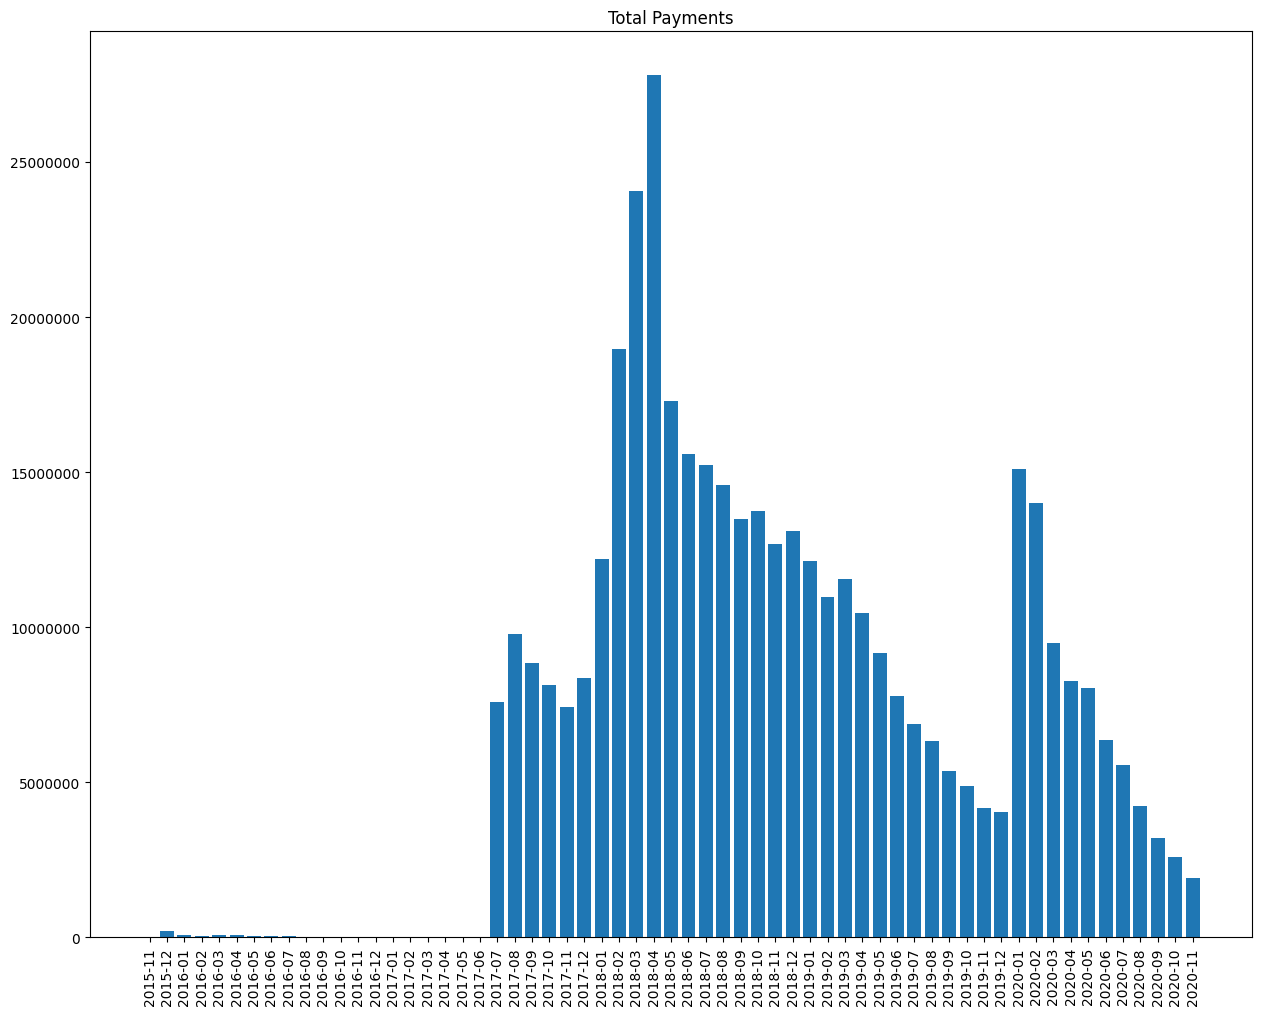

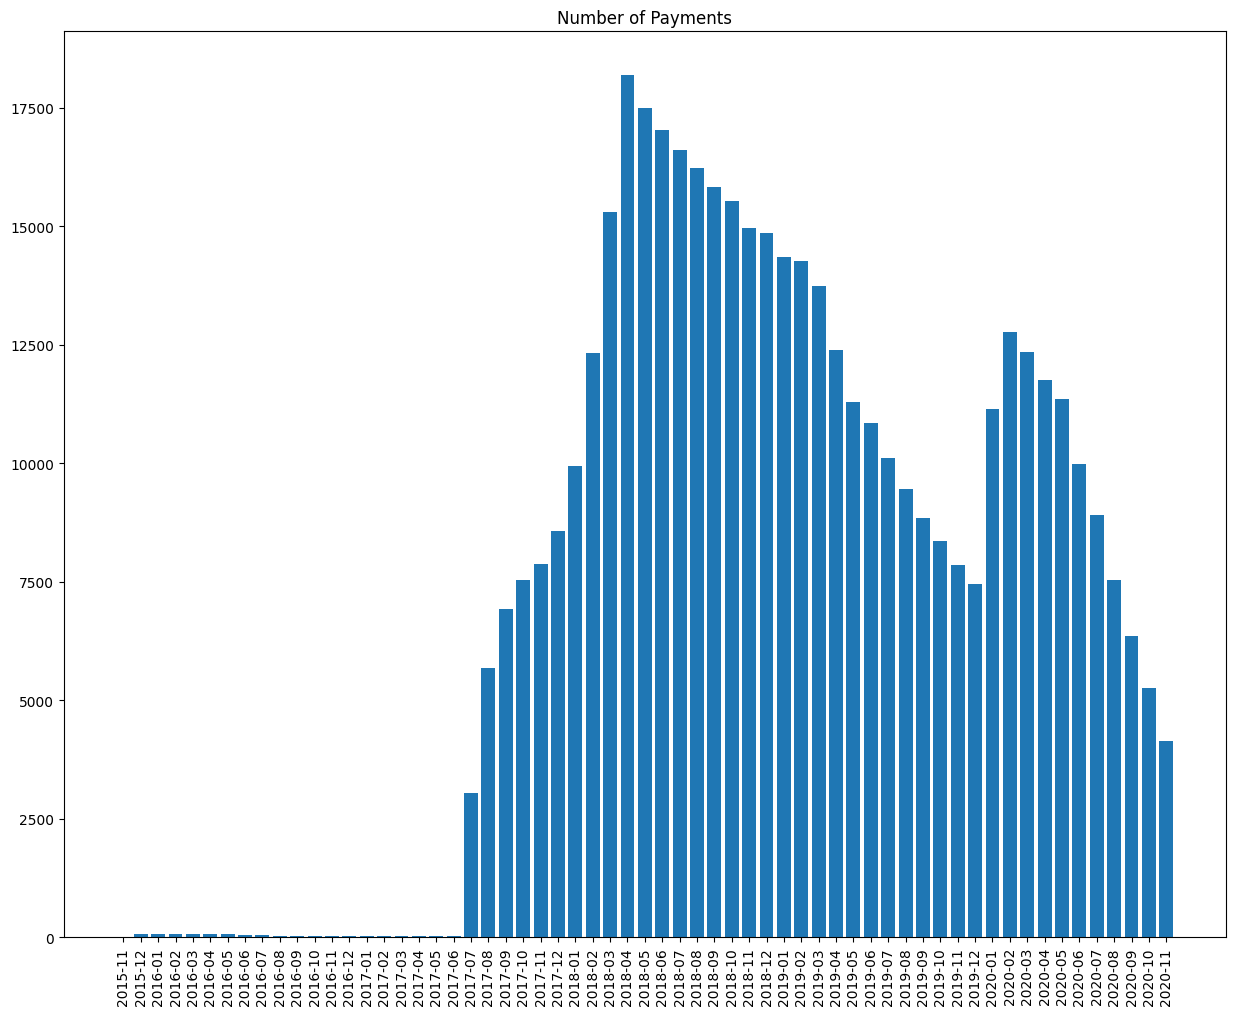

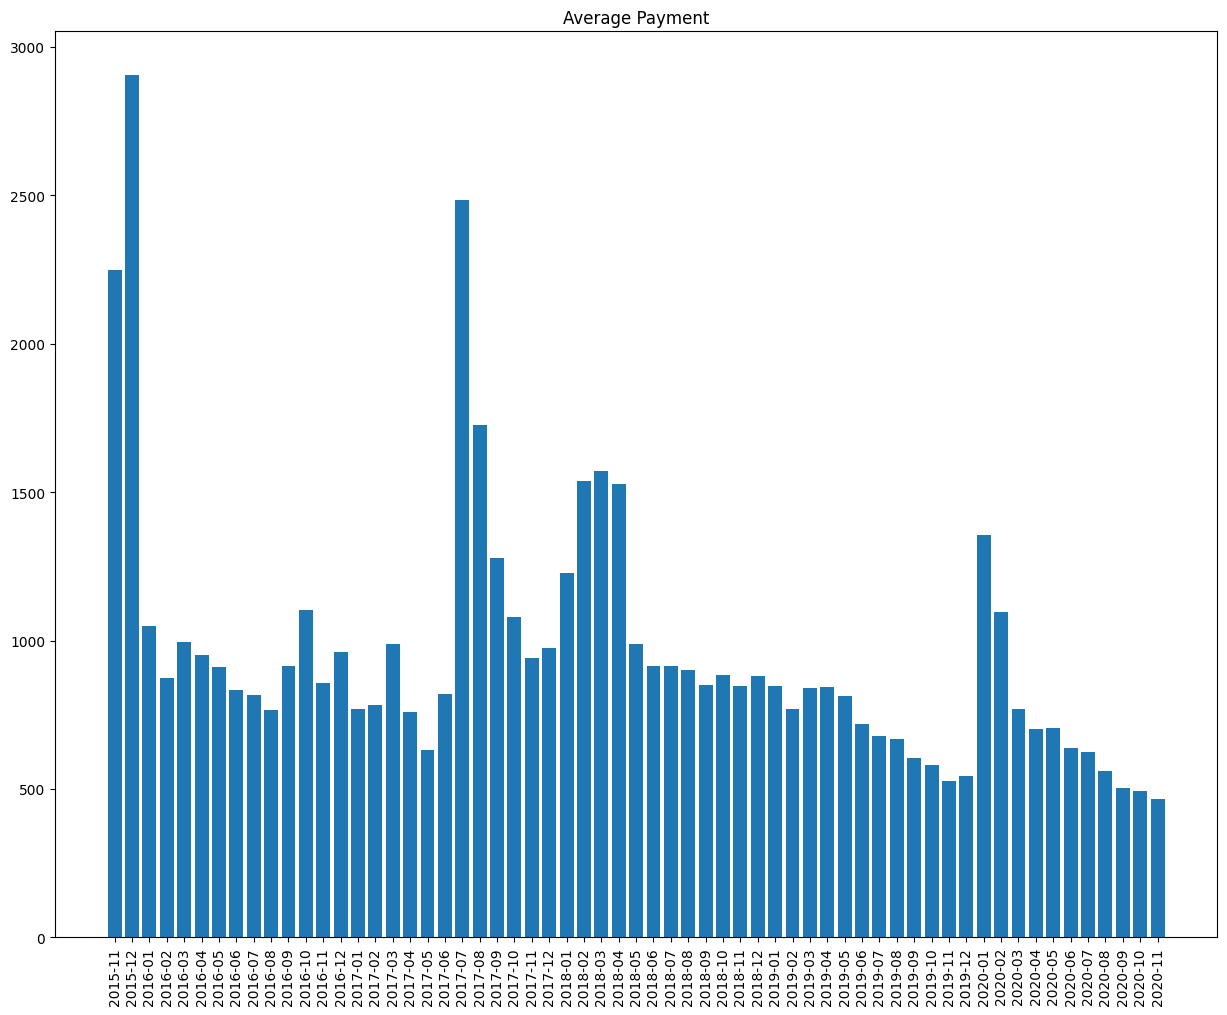

In [7]:
class DateEDA:
    def __init__(self, df):
        self.df = df
    
    @staticmethod
    def find_min_n_max(df):
        min_date = min([convert(x) for x in df.SplitTransactionDates[0]])
        max_date = max([convert(x) for x in df.SplitTransactionDates[0]])
        for i in range(train_merged.shape[0]):
            temp_min = min([convert(x) for x in df.iloc[i]["SplitTransactionDates"]])
            temp_max = max([convert(x) for x in df.iloc[i]["SplitTransactionDates"]])
            
            if temp_min < min_date:
                min_date = temp_min
            if temp_max > max_date:
                max_date = temp_max
        
        return min_date, max_date

    @staticmethod
    def find_stats(df, min_date, max_date):
        
        all_dates = [str(x) for x in pd.period_range(datetime.strptime(min_date, "%Y-%m"), datetime.strptime(max_date, "%Y-%m"), freq="M")]
        date_payments_dict = Counter({date: 0 for date in all_dates})
        date_count_dict = Counter({date: 0 for date in all_dates})
        for i in range(train_merged.shape[0]):
            # Calculates the payments made in each month
            payments_dict = {
                convert(date): float(payment)
                for date, payment in zip(
                    df.iloc[i]["SplitTransactionDates"],
                    df.iloc[i]["SplitPaymentsHistory"]
                )
            }

            # Calculates the number of payments made in each month
            count_dict = {
                convert(date): 1 for date in df.iloc[i]["SplitTransactionDates"]
            }

            date_payments_dict = Counter(payments_dict) + date_payments_dict
            date_count_dict = Counter(count_dict) + date_count_dict

        return dict(date_payments_dict), dict(date_count_dict)
    
    @staticmethod
    def calculate_avg_payments(dict1, dict2):
        return {k: round(dict1[k]/dict2[k], 2) for k in dict1}
    
    @staticmethod
    def plot(target_dict, title=""):
        target_dict = collections.OrderedDict(sorted(target_dict.items()))
        figure(figsize=(15, 12), dpi=100)
        names = list(target_dict.keys())
        values = list(target_dict.values())
        plt.ticklabel_format(style='plain')
        plt.title(title)
        plt.bar(range(len(target_dict)), values, tick_label=names)
        plt.xticks(rotation=90)
        plt.show()

    def execute(self):
        min_date, max_date = self.find_min_n_max(self.df)
        payments_dict, count_dict = self.find_stats(self.df, min_date, max_date)
        avg_payments_dict = self.calculate_avg_payments(payments_dict, count_dict)
        
        self.plot(payments_dict, "Total Payments")
        self.plot(count_dict, "Number of Payments")
        self.plot(avg_payments_dict, "Average Payment")

# DateEDA(train_merged).execute()

### Back Payment Features

In [8]:
# Add Back Payment Features


def add_back_feature(df, n=1):
    df[f"b{n}"] = df.apply(lambda row: back_feature(row["SplitPaymentsHistory"], n), axis=1)
    return df

train_merged = add_back_feature(train_merged, 1)
train_merged = add_back_feature(train_merged, 2)
train_merged = add_back_feature(train_merged, 3)
train_merged = add_back_feature(train_merged, 4)
train_merged = add_back_feature(train_merged, 5)

### Date Related Features

TODO: 
1. Skipped payments and duration of skipping payments
2. Check for custom seasonality (Weather changes EDA)

### Backward Feature elimination

In [9]:
train_merged["RegistrationDateParsed"] = pd.to_datetime(train_merged["RegistrationDate"], infer_datetime_format=True)
train_merged["ExpectedTermDateParsed"] = pd.to_datetime(train_merged["ExpectedTermDate"], infer_datetime_format=True)
train_merged["FirstPaymentDateParsed"] = pd.to_datetime(train_merged["FirstPaymentDate"], infer_datetime_format=True)
train_merged["LastPaymentDateParsed"] = pd.to_datetime(train_merged["LastPaymentDate"], infer_datetime_format=True)

train_merged["RegistrationDate"] = pd.to_datetime(train_merged["RegistrationDate"], infer_datetime_format=True).dt.date
train_merged["ExpectedTermDate"] = pd.to_datetime(train_merged["ExpectedTermDate"], infer_datetime_format=True).dt.date
train_merged["FirstPaymentDate"] = pd.to_datetime(train_merged["FirstPaymentDate"], infer_datetime_format=True).dt.date
train_merged["LastPaymentDate"] = pd.to_datetime(train_merged["LastPaymentDate"], infer_datetime_format=True).dt.date

In [10]:
train_merged["LastFirstDuration"] = (train_merged.LastPaymentDate - train_merged.FirstPaymentDate).astype("timedelta64[M]")
train_merged["ExpectedFirstDuration"] = (train_merged.ExpectedTermDate - train_merged.FirstPaymentDate).astype("timedelta64[M]")
train_merged["LastRegistrationDuration"] = (train_merged.LastPaymentDate - train_merged.RegistrationDate).astype("timedelta64[M]")

In [11]:
# Months
train_merged["FirstPaymentMonth"] = train_merged["FirstPaymentDateParsed"].dt.month
train_merged["LastPaymentMonth"] = train_merged["LastPaymentDateParsed"].dt.month
train_merged["RegistrationMonth"] = train_merged["RegistrationDateParsed"].dt.month

# # Sine
# train_merged["FirstPaymentMonthSin"] = np.sin((train_merged.FirstPaymentMonth-1)*(2.*np.pi/12))
# train_merged["LastPaymentMonthSin"] = np.sin((train_merged.LastPaymentMonth-1)*(2.*np.pi/12))
# train_merged["RegistrationMonthSin"] = np.sin((train_merged.RegistrationMonth-1)*(2.*np.pi/12))

# # Cos
# train_merged["FirstPaymentMonthCos"] = np.cos((train_merged.FirstPaymentMonth-1)*(2.*np.pi/12))
# train_merged["LastPaymentMonthCos"] = np.cos((train_merged.LastPaymentMonth-1)*(2.*np.pi/12))
# train_merged["RegistrationMonthCos"] = np.cos((train_merged.RegistrationMonth-1)*(2.*np.pi/12))

In [12]:
train_merged.drop(["RegistrationDateParsed", "ExpectedTermDateParsed", "FirstPaymentDateParsed", "LastPaymentDateParsed"], axis=1, inplace=True)

### We can ignore UpSell since it represents only 2.7% of the rows

In [13]:
train_merged.UpsellDate.count() / train_merged.shape[0] * 100

2.6493376655836043

In [14]:
train_merged.nb_payments.describe()

count    28007.000000
mean        16.262363
std          9.248264
min          5.000000
25%          8.000000
50%         14.000000
75%         23.000000
max         52.000000
Name: nb_payments, dtype: float64

### Drop irrelevant columns

In [15]:
def drop_cols(df):
    df.drop(
        [
            "ID",
            "UpsellDate",
            "PaymentMethod",
            "TransactionDates",
            "PaymentsHistory",
            "SupplierName",
            "Town"
        ],
        inplace=True,
        axis=1
    )
drop_cols(train_merged)

In [16]:
train_merged.head()

RegistrationDate  Deposit  AccessoryRate rateTypeEntity  RatePerUnit  \
0       2018-04-23     2500            0.0          DAILY           55   
1       2018-04-17     2500            0.0          DAILY           55   
2       2020-02-18     2400            0.0          DAILY           50   
3       2017-09-14     2000            0.0          DAILY           40   
4       2017-09-06     2000            0.0          DAILY           40   

   DaysOnDeposit MainApplicantGender   Age              Region Occupation  \
0              3                Male   NaN        Coast Region    Teacher   
1              3                Male  26.0          South Rift     Farmer   
2              3                Male  21.0  Mount Kenya Region   Business   
3              7              Female  26.0  Mount Kenya Region     Farmer   
4              7                Male  27.0          North Rift     Farmer   

   ...     b2      b3      b4      b5 LastFirstDuration  \
0  ...  280.0  1320.0  1200.0   660.0              37.0   
1  ...  655.0   660.0   660.0   605.0              37.0   
2  ...  200.0   610.0  1350.0  1500.0              11.0   
3  ...  600.0  1100.0  1300.0   780.0              15.0   
4  ...   80.0    40.0    40.0    80.0              44.0   

   ExpectedFirstDuration  LastRegistrationDuration  FirstPaymentMonth  \
0                   18.0                      37.0                  4   
1                   18.0                      37.0                  4   
2                    7.0                      11.0                  2   
3                   11.0                      15.0                  9   
4                   11.0                      44.0                  9   

   LastPaymentMonth  RegistrationMonth  
0                 5                  4  
1                 5                  4  
2                 1                  2  
3                12                  9  
4                 5                  9  

[5 rows x 43 columns]

### Feature Encoding

In [17]:
# OHE

def encode_and_bind(df, feature_name):
    dummies = pd.get_dummies(df[[feature_name]])
    res = pd.concat([df, dummies], axis=1)
    res = res.drop([feature_name], axis=1)
    return(res)

for feature in ["MainApplicantGender", "Region", "Occupation", "rateTypeEntity"]:
    train_merged = encode_and_bind(train_merged, feature)

In [18]:
train_merged.head()

RegistrationDate  Deposit  AccessoryRate  RatePerUnit  DaysOnDeposit   Age  \
0       2018-04-23     2500            0.0           55              3   NaN   
1       2018-04-17     2500            0.0           55              3  26.0   
2       2020-02-18     2400            0.0           50              3  21.0   
3       2017-09-14     2000            0.0           40              7  26.0   
4       2017-09-06     2000            0.0           40              7  27.0   

   Term  TotalContractValue ExpectedTermDate FirstPaymentDate  ...  \
0   556             33080.0       2019-10-31       2018-04-23  ...   
1   556             33080.0       2019-10-25       2018-04-17  ...   
2   240             14400.0       2020-10-15       2020-02-18  ...   
3   364             16560.0       2018-09-13       2017-09-14  ...   
4   364             16560.0       2018-09-05       2017-09-06  ...   

  Occupation_Business  Occupation_Driver/Motorbike Rider  Occupation_Farmer  \
0                   0                                  0                  0   
1                   0                                  0                  1   
2                   1                                  0                  0   
3                   0                                  0                  1   
4                   0                                  0                  1   

   Occupation_Government Employee  Occupation_Labourer  Occupation_Other  \
0                               0                    0                 0   
1                               0                    0                 0   
2                               0                    0                 0   
3                               0                    0                 0   
4                               0                    0                 0   

   Occupation_Teacher rateTypeEntity_DAILY rateTypeEntity_MONTHLY  \
0                   1                    1                      0   
1                   0                    1                      0   
2                   0                    1                      0   
3                   0                    1                      0   
4                   0                    1                      0   

   rateTypeEntity_WEEKLY  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 58 columns]

In [19]:
train_merged.drop(["RegistrationDate", "ExpectedTermDate", "FirstPaymentDate", "LastPaymentDate", "SplitPaymentsHistory", "SplitTransactionDates", "m2", "m3", "m4", "m5", "m6"], inplace=True, axis=1)


### Data Leakage here. Will be handled later.

In [20]:
# train_merged.Age.plot()

In [21]:
train_merged.Age = train_merged.Age.fillna(train_merged.Age.mean())

In [22]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

np.random.seed(0)
def predict_model(train_array, target):
    model = xgb.XGBRegressor(use_label_encoder=False,
                             verbosity=0,
                             objective="reg:squarederror",
                             reg_lambda=0,
                             reg_alpha=50)
    
    X_train, X_test, y_train, y_test = train_test_split(train_array, target, test_size=0.20)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    feature_importance = model.feature_importances_
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = pow(mse, 0.5)
    
    print("---------TEST---------")
    print("Predictions")
    print(y_pred)
    print("RMSE:", rmse)
    
    y_pred = model.predict(X_train)
    feature_importance = model.feature_importances_
    mape = mean_absolute_percentage_error(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    rmse = pow(mse, 0.5)
    
    print("---------TRAIN--------")
    print(y_pred)
    print("RMSE:", rmse)
    
    return y_pred, mape, mse, feature_importance, rmse

predict_model(train_merged.drop(["m1"], axis=1), train_merged["m1"])

---------TEST---------
Predictions
[1477.4286  1021.2322   112.53637 ...  143.60129 1556.4016   636.3163 ]
RMSE: 571.6337696155097
---------TRAIN--------
[ 25.5406  397.4751  571.12256 ... 396.71854 614.89233 316.2344 ]
RMSE: 215.20357962609893


(array([ 25.5406 , 397.4751 , 571.12256, ..., 396.71854, 614.89233,
        316.2344 ], dtype=float32),
 0.715271630243632,
 46312.5806838867,
 array([0.00722813, 0.00798009, 0.00714374, 0.02108898, 0.09735171,
        0.02184729, 0.03809092, 0.01492404, 0.02295504, 0.03030197,
        0.03501572, 0.07785226, 0.0458695 , 0.00791241, 0.01215152,
        0.02043544, 0.2721522 , 0.04775279, 0.03466507, 0.00905409,
        0.00829698, 0.01734081, 0.        , 0.01137633, 0.00864626,
        0.00983855, 0.0048418 , 0.00580323, 0.        , 0.00807291,
        0.01163978, 0.00614947, 0.00858311, 0.00774576, 0.00609271,
        0.00392241, 0.00588077, 0.00569985, 0.0070429 , 0.00860206,
        0.00469985, 0.01111628, 0.00683533, 0.        , 0.        ,
        0.        ], dtype=float32),
 215.20357962609893)

### Outlier Handling
### Advance Modelling
### EDA for adding time features
### Scaling & Normalization